In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
from scipy.optimize import minimize
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.stats import norm
import calendar
np.random.seed(20180903)

#### 1. Kalman Filter Class 정의

In [2]:
class KalmanFilter:
    def __init__(self, A, B, Q, H, R):
        self.A = A
        self.B = B
        self.Q = Q
        self.H = H
        self.R = R
    
    def Predict(self, inputs):
        x, P = inputs
        x_pred = np.dot(self.A,x)+self.B
        P_pred = np.dot(np.dot(self.A,P),self.A.T) + self.Q
        return x_pred, P_pred
    
    def Update(self, update, z_meas):
        x_pred, P_pred = update
        z_pred = np.dot(self.H, x_pred)
        v = z_meas.reshape(-1,1) - z_pred
        F = np.dot(np.dot(self.H, P_pred),self.H.T) + self.R
        K = np.dot(np.dot(P_pred, self.H.T), linalg.inv(F))
        x_update = x_pred + np.dot(K, v)
        P_update = P_pred - np.dot(np.dot(K, self.H), P_pred)
        dF = linalg.det(F)
        if dF <= 0:
            print('Warning : dF <= 0 인 경우가 있습니다.')
            dF = 1e-70
        logL = -0.5*np.log(2*np.pi) - 0.5*np.log(dF) - 0.5* np.dot(v.T, np.dot(linalg.inv(F), v))
        # -logL를 minimize 해야 함
        return x_update, P_update, -logL[0][0]

#### 2. 데이터 입력

In [3]:
data = np.array(pd.read_csv('./data/KIS_spot_continuous_montly_201612.csv'))

In [4]:
# System
def set_param(param):
        dt = 1/12
        tau = [0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 5, 7, 10, 15, 20]
        lambda_, eps, kappa1, kappa2, kappa3, theta1, theta2, theta3, sigma1, sigma2, sigma3, rho12, rho13, rho23 = param
        
        # κ > 0 이라는 조건 때문에 넣음
        kappa1 = abs(kappa1)
        kappa2 = abs(kappa2)
        kappa3 = abs(kappa3)
        
        # 상태 입력
        A = np.array([[1-kappa1*dt, 0, 0],
                      [0, 1-kappa2*dt, 0],
                      [0, 0, 1-kappa3*dt]])
        B = np.array([[kappa1*theta1],
                      [kappa2*theta2],
                      [kappa3*theta3]])
        Q = np.array([[sigma1**2, sigma1*sigma2*rho12, sigma1*sigma3*rho13],
                      [sigma1*sigma2*rho12, sigma2**2, sigma2*sigma3*rho23],
                      [sigma1*sigma3*rho13, sigma2*sigma3*rho23, sigma3**2]])
        H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t)-np.exp(-lambda_*t)] for t in tau])
        R = np.identity(len(tau))*eps**2
        
        return A, B, Q, H, R

In [5]:
def get_states(kf, data):
    # Input Initial State
    x0 = np.array([0.06,-0.02,0]).reshape(-1,1)
    P0 = np.identity(3)*10
    
    n = data.shape[0]
    states = np.zeros([n+1,3])
    states[0] = x0.reshape(3)
    
    for i in range(n):
        x1, P1 = kf.Predict([x0, P0])
        x0, P0, ll = kf.Update([x1, P1], data[i,:])
        states[i+1] = x0.reshape(3)
    return states

In [6]:
def get_loglik(kf, data):
    # Input Initial State
    x0 = np.array([0.06,-0.02,0]).reshape(-1,1)
    P0 = np.identity(3)*10
    
    n = data.shape[0]
    loglik = np.zeros(n)
    
    for i in range(n):
        x1, P1 = kf.Predict([x0, P0])
        x0, P0, ll = kf.Update([x1, P1], data[i,:])
        loglik[i] = ll
    return loglik.sum()

In [7]:
def obj(param):
    A,B,Q,H,R = set_param(param)
    kf = KalmanFilter(A,B,Q,H,R)
    res = get_loglik(kf,data)
    if np.random.randint(500) == 0:
        print('Loglikelihood is... : {}'.format(-res))
    return res

#### 3. 모수 최적화

In [8]:
# Optimization
param = np.loadtxt('param.txt')
res = minimize(fun=obj, x0=param, method='nelder-mead', options={'disp': True, 'maxiter':1000})

Loglikelihood is... : 11279.47588956001
Loglikelihood is... : 11279.44547093959
Loglikelihood is... : 11279.435720309879
Loglikelihood is... : 11279.468764970588
Loglikelihood is... : 11279.540710744019
Optimization terminated successfully.
         Current function value: -11279.540711
         Iterations: 317
         Function evaluations: 1057


In [13]:
np.savetxt('param.txt', res.x)
print('lambda_, eps, kappa1, kappa2, kappa3, theta1, theta2, theta3, sigma1, sigma2, sigma3, rho12, rho13, rho23')
print([round(x, 4) for x in param])

lambda_, eps, kappa1, kappa2, kappa3, theta1, theta2, theta3, sigma1, sigma2, sigma3, rho12, rho13, rho23
[0.5588, 0.0005, 0.0266, 0.3114, 1.3563, -0.0046, -0.0013, -0.0006, 0.0021, 0.0029, 0.0052, -0.645, -0.0071, -0.0181]


#### 4. 충격 시나리오

In [14]:
# 상태 입력
lambda_, eps, kappa1, kappa2, kappa3, theta1, theta2, theta3, sigma1, sigma2, sigma3, rho12, rho13, rho23 = param
dt = 1/12

kappa = np.array([kappa1,kappa2,kappa3]).reshape(-1,1)
theta = np.array([theta1,theta2,theta3]).reshape(-1,1)
Q = np.array([[sigma1**2, sigma1*sigma2*rho12, sigma1*sigma3*rho13],
              [sigma1*sigma2*rho12, sigma2**2, sigma2*sigma3*rho23],
              [sigma1*sigma3*rho13, sigma2*sigma3*rho23, sigma3**2]])
S = linalg.cholesky(Q)

In [15]:
X0 = np.array([0.06,-0.02,0]).reshape(-1,1)
M = np.dot(1/kappa*np.identity(3)*(1-np.exp(-kappa)),S)

LOT = 20
N0 = np.sum(np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t)-np.exp(-lambda_*t)] for t in range(1,21)]), axis=0)
N = np.dot(N0*np.identity(3), M)
eig_values, E = np.linalg.eig(np.dot(N.T, N))

e1 = E[:,0].reshape(3,1)
e2 = E[:,1].reshape(3,1)
S1 = np.dot(N0,np.dot(M, e1))[0]
S2 = np.dot(N0,np.dot(M, e2))[0]
arg = np.arctan(S2/S1)

# 충격 산출
T = np.dot(np.identity(3)*(1-np.exp(-kappa)), theta - X0)
Level = (np.cos(arg)*np.dot(M,e1) + np.sin(arg)*np.dot(M,e2))*norm.ppf(0.995)
Twist = (np.cos(arg)*np.dot(M,e2) - np.sin(arg)*np.dot(M,e1))*norm.ppf(0.995)

#### 5. 시각화

In [16]:
# Result
A,B,Q,H,R = set_param(param)
kf = KalmanFilter(A,B,Q,H,R)
states = get_states(kf, data)
lambda_ = param[0]
tau = [0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 5, 7, 10, 15, 20]
H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t)-np.exp(-lambda_*t)] for t in tau])

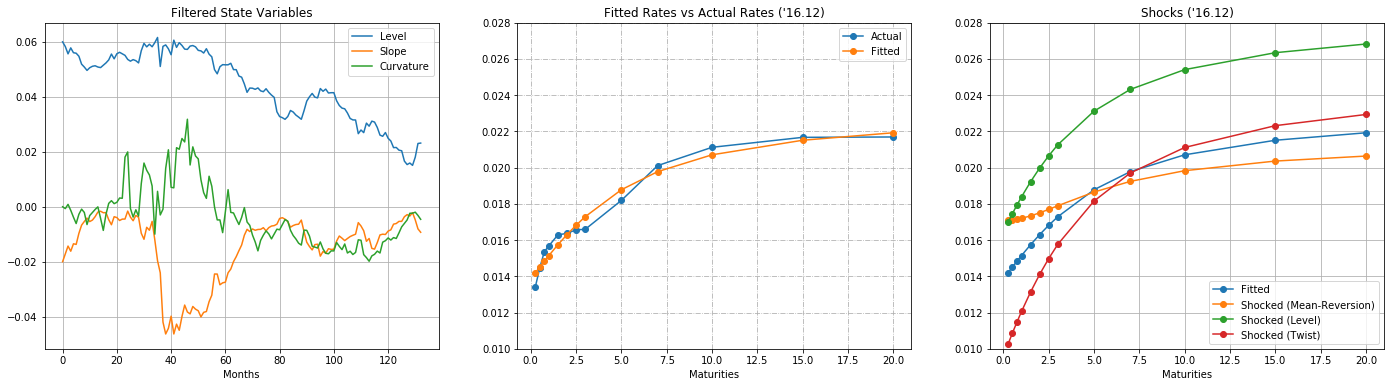

In [32]:
# Visualization
fig, ax = plt.subplots(1,3, figsize=(24,6))

# Filtered State Variables
titles = ['Level', 'Slope', 'Curvature']
for i in range(3):
    ax[0].plot(states[:,i], label=titles[i])
ax[0].set_xlabel('Months')
ax[0].set_title('Filtered State Variables')
ax[0].grid()
ax[0].legend()

# Fitted Rates vs Actual Rates
# 2006년 1월 = 0, 2006년 2월 = 1 ...
i = -1
ax[1].plot(tau, data[i,], '-o', label='Actual')
ax[1].plot(tau, np.dot(H, states[i]), '-o', label='Fitted')
ax[1].set_xlabel('Maturities')
ax[1].legend()
ax[1].set_title('Fitted Rates vs Actual Rates (\'16.12)')
ax[1].grid(True, linestyle='-.')
ax[1].set_ylim([0.01,0.028])

# Shocks
ax[2].plot(tau, np.dot(H, states[i]), '-o', label='Fitted')
ax[2].plot(tau, np.dot(H, states[i]+T.reshape(3)), '-o', label='Shocked (Mean-Reversion)')
ax[2].plot(tau, np.dot(H, states[i]+Level.reshape(3)), '-o', label='Shocked (Level)')
ax[2].plot(tau, np.dot(H, states[i]+Twist.reshape(3)), '-o', label='Shocked (Twist)')
ax[2].set_xlabel('Maturities')
ax[2].legend()
ax[2].set_title('Shocks (\'16.12)')
ax[2].grid(True, linestyle='-')
ax[2].set_ylim([0.01,0.028])

plt.show()